# Emcee Testing

## Simple Lorentzian No Background

In [12]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

#sig_dist = sp.stats.halfcauchy
#signal = sig_dist.rvs(scale=kappa, loc=0.0, size=nsig)

bg = np.random.uniform(xrange[0], xrange[1], nbg)

events = curv.data
#events = np.concatenate((curv.data, bg))


[0.0001]
Generated 10000 samples using parameters [0.01111111]


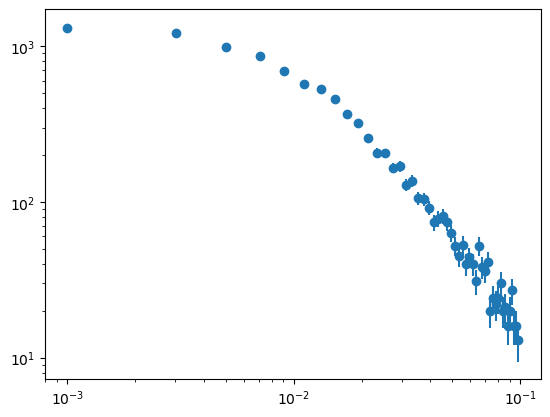

In [13]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [14]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim:
        return 0.0
    
    return -np.inf

def pmf(xvals, theta):
    
    kappa = np.asarray(theta)
    
    result = curv.curve(kappa, dat=xvals)    
    return result


def log_likelihood(theta):
    kappa = np.asarray(theta)
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    ll = curv.llcurve(kappa)
    
    result = lp + ll
    
    if np.isnan(result):
        print("NaN result for theta, prior", theta, lp)
    
    return result


p0 = np.array([0.02])


print(log_likelihood(p0))

21778.826657413105


In [15]:
ndim, nwalkers = 1, 32

p0 = np.array(0.02)

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 510.42it/s]


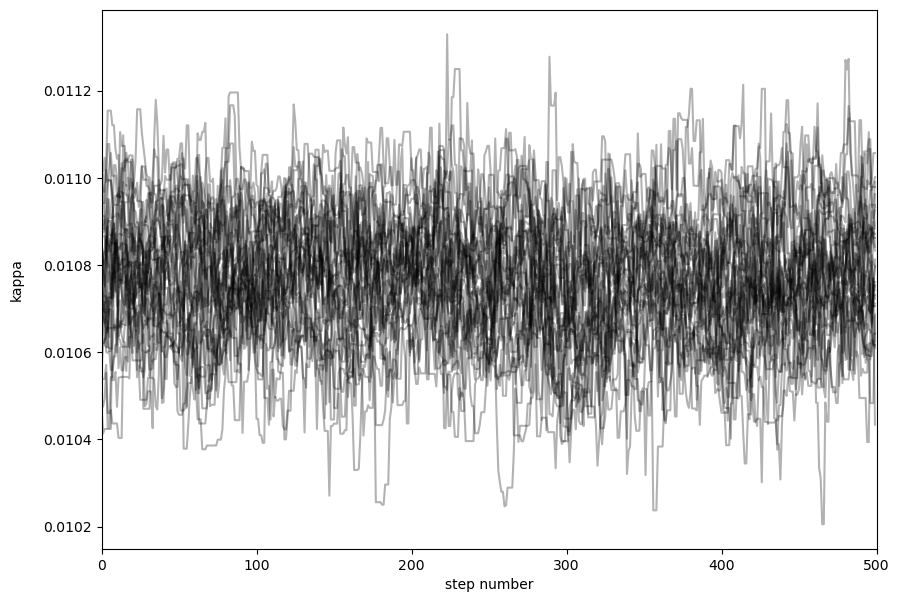

In [16]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa"]
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel(labels[0])
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xlabel("step number");

Text(0.5, 0, 'Q (Å-1)')

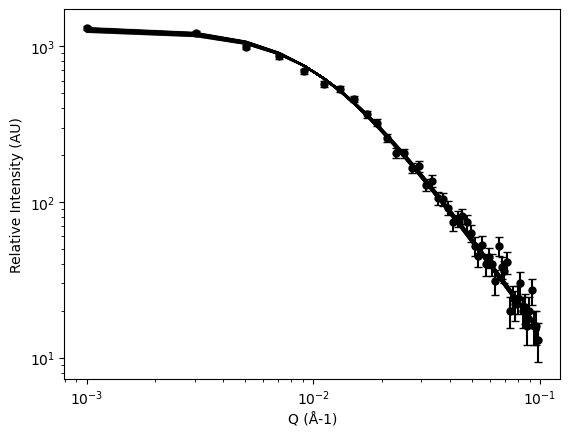

In [17]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')

## Lorentzian With Background

In [18]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000

ratio = float(nsig) / float(nbg)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

curv.generate_background(xrange, ratio = ratio)


events = curv.data

[0.0001]
Generated 10000 samples using parameters [0.01111111]
Adding flat background of 10000.0 points


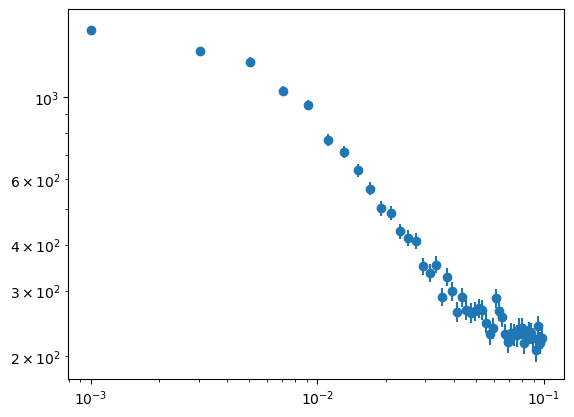

In [19]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [155]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, logQ = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim and -7.0 < logQ < 2.0:# and 0.1 < sigma < 3.0:
        return 0.0
    
    return -np.inf

def get_color(xvals, theta):
    # Figure out the color of the point based on its signal likelihood
    kappa, logQ = theta
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = yvals / (yvals + Q)
    
    color_r = 1.0-yweight
    color_g = np.full_like(yweight, 0.5)
    color_b = yweight
    
    color = np.stack((color_r, color_g, color_b), axis=1)
    
    print("yvals", yvals)
    print("Q", Q)
    print("yweight", yweight)
    
    return color
    

def pmf(xvals, theta):
    gaus = sp.stats.norm
    
    kappa, logQ = theta
    
    Q = 10.0**logQ
     
    yvals = curv.curve(np.array([kappa]), dat=xvals)
    
    yweight = yvals / (yvals + Q)
    
    term1 = yvals * yweight
    term2 = Q #* (1.0 - yweight) # ) * gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    result = term1 + term2
    
    return result

def log_gaussian(sigma):
    xvals = curv.data
    gaus = sp.stats.norm
    
    gvals = gaus.pdf(x=xvals, loc=0.0, scale=sigma)
    
    log_gvals = np.log(gvals)
    
    slog_gvals = np.sum(log_gvals)
    
    return slog_gvals
    

def log_likelihood(theta):
    kappa, logQ = theta
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    sig_Q = curv.curve(np.array([kappa]), dat=xvals)
    bgQ = 10.0**logQ
    weights = sig_Q / (sig_Q + bgQ)
    
    bg_weights = 1.0 - weights
    
    log_weights = np.log(weights)
    log_bg_weights = np.log(bg_weights) 
    ll = np.log(sig_Q)
    
    weighted_ll = ll + log_weights
    
    weighted_ll_sum = np.sum(weighted_ll)
    
    #ll = curv.llcurve(np.array([kappa]))
    #if np.isnan(ll):
    #    print("NaN result for theta, prior", theta, lp)

    # bg in this case is a wide gaussian, if it's wide enough it's flat
    # also, Q=0 is zero background (never happens because logQ is of course 
    # on a log scale
    ##lbg = logQ + log_gaussian(sigma)
    
    result = lp + weighted_ll_sum#, arg1, lbg
    

    
    return result


p0 = np.array([0.02, -0.9])


print(log_likelihood(p0))

44.40363466109205


In [100]:
ndim, nwalkers = 2, 32

p0 = np.array([0.02, -0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [00:00<00:00, 1944.10it/s]


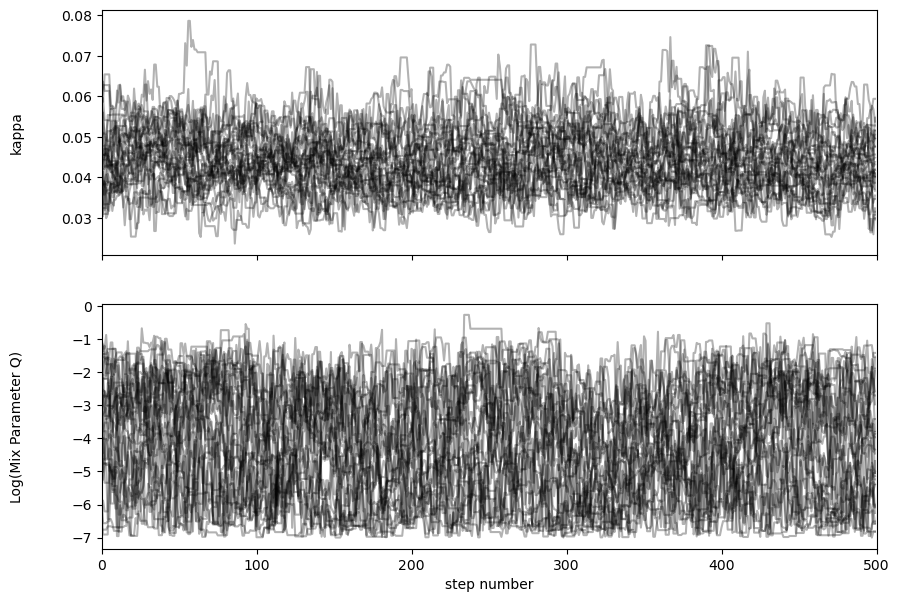

In [101]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa", "Log(Mix Parameter Q)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [124]:
flat_samples[inds[0]]


array([ 0.04960291, -0.95047606])

yvals [7.15542244 7.12612323 7.0681296  6.98283439 6.87222462 6.73876966
 6.58529084 6.4148245  6.23048976 6.0353698  5.83241303 5.62435705
 5.41367611 5.20255032 4.99285362 4.78615704 4.58374314 4.38662835
 4.19558984 4.01119459 3.83382869 3.66372547 3.50099164 3.34563087
 3.19756464 3.05665028 2.92269634 2.79547552 2.67473536 2.56020698
 2.45161213 2.34866882 2.25109568 2.15861537 2.07095711 1.98785853
 1.90906702 1.83434057 1.76344828 1.69617066 1.63229958 1.57163822
 1.51400077 1.4592121  1.4071074  1.35753167 1.3103393  1.26539359
 1.22256626]
Q 2.3480748227999963e-05
yweight [0.99999672 0.9999967  0.99999668 0.99999664 0.99999658 0.99999652
 0.99999643 0.99999634 0.99999623 0.99999611 0.99999597 0.99999583
 0.99999566 0.99999549 0.9999953  0.99999509 0.99999488 0.99999465
 0.9999944  0.99999415 0.99999388 0.99999359 0.99999329 0.99999298
 0.99999266 0.99999232 0.99999197 0.9999916  0.99999122 0.99999083
 0.99999042 0.99999    0.99998957 0.99998912 0.99998866 0.99998819
 0.9999877

Text(0.5, 0, 'Q (Å-1)')

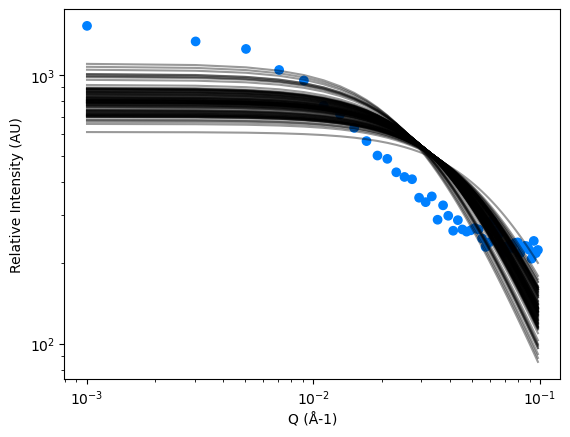

In [156]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

#plt.errorbar(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]), yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
plt.scatter(xvals, yvals, color=get_color(xvals, flat_samples[inds[0]]))

#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
#plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')